In [109]:
import torch
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
from torchvision import models
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
import sys
from torchvision import transforms
import time
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append("..")

from utils.utils import (
    get_pneumonia_images,
    PneumoniaDataset,
    set_all_seeds,
    train_and_validate,
    test,
    EarlyStopping,
)

In [27]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # use pretrained resnet 50
        self.resnet = models.resnet50(pretrained=True)
        # replace fully connected layer
        self.resnet.fc = nn.Sequential(
            nn.LazyLinear(2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            # return one output for binary classification with BCEWithLogitsLoss
            nn.Linear(2048, 2),
        )

    def forward(self, x):
        # squeeze to make sure dimension is compatible with BCEWithLogitsLoss
        return self.resnet(x)
    
    def __repr__(self):
        return repr(self.resnet)


In [29]:
model = CNN().to(DEVICE)

In [32]:
checkpoint = torch.load("C:/Users/gianf/Desktop/ETH/II_Semestre/ML4HC/ML4Healthcare/project1/task2/cnn/cnn_all_unfrozen.pth", map_location=DEVICE)


In [33]:
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [34]:
# Load test images and test labels
test_images, test_labels = get_pneumonia_images(
    "C:/Users/gianf/Desktop/ETH/II_Semestre/ML4HC/ML4Healthcare/project1/task2/data/chest_xray/test")


Reading PNEUMONIA test images: 100%|██████████| 390/390 [00:04<00:00, 80.67it/s] 


In [47]:
transform = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor()])


In [82]:
def test_single_image(
    model: nn.Module,
    image: torch.Tensor,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
) -> float:
    """Test loop for a single image. Returns the predicted label for the image.

    Args:
        model (nn.Module): A neural network model.
        image (torch.Tensor): Single input image.
    Returns:
        float: Predicted label for the image.
    """
    model.eval()
    with torch.no_grad():
        logits = model(image.to(device))[0]
        # If logits has only one dimension, it's likely a single output node
        # Here, we'll treat it as binary classification
        probs = F.softmax(logits.unsqueeze(0), dim=1)[0][1].cpu().numpy()
        predicted_label = probs.round().astype(float)
        return predicted_label




In [87]:
# Pick five different images from the test dataset with true label and expected label equal to the desired one
def get_image_idx(test_dataset,lable_dataset, n, lable):
    count = 0
    index = []
    for i in range(len(lable_dataset)):
        test_img = test_dataset[i]
        transformed_img = transform(test_img)
        input_img = transformed_img.unsqueeze(0) # the model requires a dummy batch dimension
        pred_label = int(test_single_image(model,input_img))
        if  count < n and lable_dataset[i] == lable and pred_label == lable:
            index.append(i)
            count += 1
        if count == n:
            break
    return index


In [98]:
n_img = 5
# Gettind the images with index 0
idx0 = get_image_idx(test_images,test_labels, n_img, 0)

In [ ]:
# Gettind the images with index 1
idx1 = get_image_idx(test_images,test_labels, n_img, 1)

In [102]:
idx0

[0, 1, 2, 3, 4]

In [89]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

In [90]:
def get_attribution(indx,test_images):
    attr_list = []

    for i in indx:
        test_img = test_images[i]
        transformed_img = transform(test_img)
        input_img = transformed_img.unsqueeze(0) # the model requires a dummy batch dimension
        pred_label = int(test_single_image(model,input_img))
        # Ask the algorithm to attribute our output target to
        attr_list.append(integrated_gradients.attribute(input_img, target=pred_label, n_steps=200))
    return attr_list

In [103]:
# Getting attributes for index 0
attr_idx0 = get_attribution(idx0,test_images)

In [94]:
# Getting attributes for index 1
attr_idx1 = get_attribution(idx1,test_images)

tensor([[[[ 5.6991e-03,  5.5979e-03,  1.4376e-03,  ...,  8.8577e-04,
           -3.6906e-04,  1.4027e-03],
          [ 4.2921e-03,  1.5822e-02,  6.9654e-03,  ..., -2.5584e-04,
           -3.0695e-04, -9.1478e-04],
          [ 1.9155e-03,  1.4026e-02,  4.8222e-03,  ..., -1.0118e-03,
           -1.0907e-03, -1.1138e-03],
          ...,
          [-6.5960e-03, -1.2456e-02, -1.7708e-02,  ..., -3.2781e-03,
           -1.1658e-03, -1.5281e-03],
          [-1.9992e-03, -4.0653e-03,  1.9462e-03,  ...,  3.4815e-03,
           -8.9933e-04, -3.1559e-03],
          [ 8.1103e-04, -2.5094e-04, -1.5118e-03,  ...,  1.6553e-03,
           -6.6176e-04, -3.9082e-03]],

         [[ 3.0877e-03,  6.1712e-03,  7.5454e-03,  ...,  5.5666e-04,
           -1.0314e-03,  4.3393e-04],
          [ 8.5691e-03,  1.4858e-02,  2.2184e-03,  ...,  7.1225e-04,
            1.3151e-04, -1.4977e-03],
          [ 1.4548e-02,  1.6628e-02, -5.6558e-03,  ..., -3.0649e-04,
            1.8964e-04, -4.2207e-04],
          ...,
     

IndexError: list index out of range

Predicted label 0, true label 0


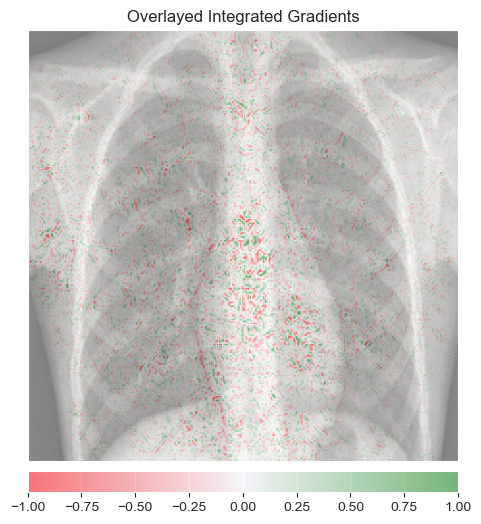

Predicted label 0, true label 0


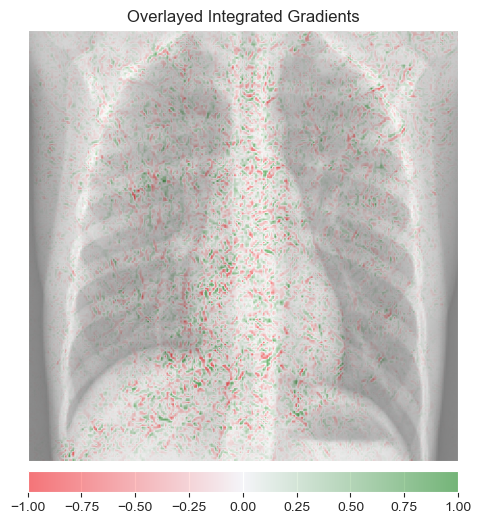

Predicted label 0, true label 0


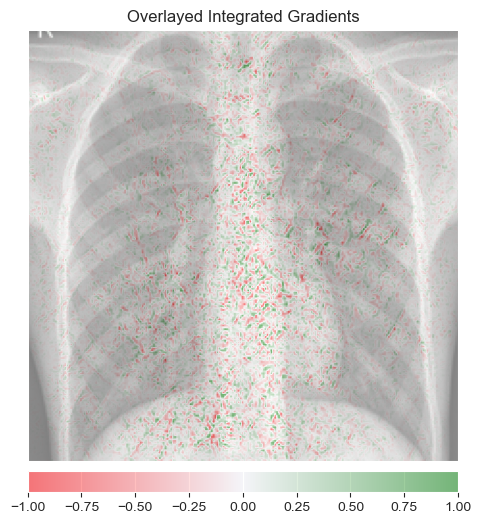

Predicted label 0, true label 0


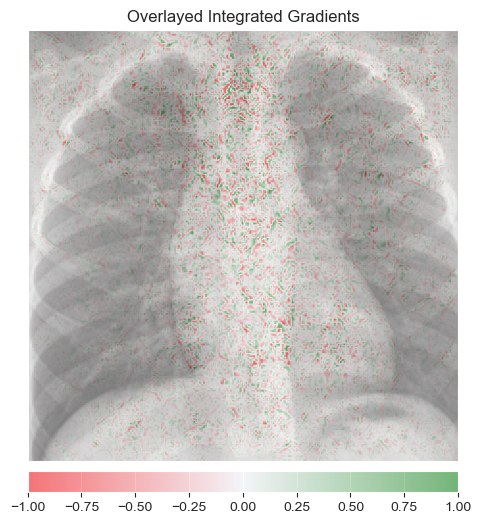

Predicted label 0, true label 0


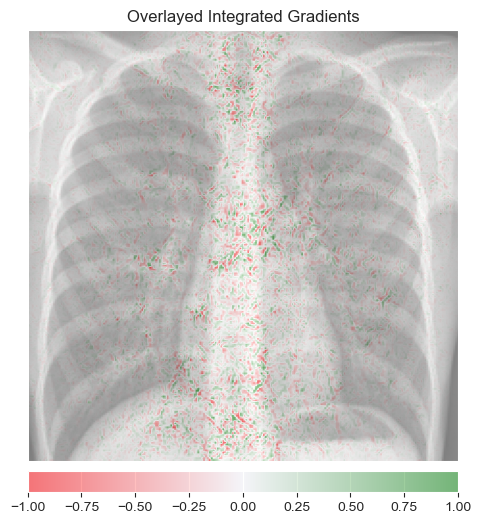

In [111]:
for i in range(len(attr_idx0)):
    test_img = test_images[idx0[i]]
    true_label = test_labels[idx0[i]]
    transformed_img = transform(test_img)
    input_img = transformed_img.unsqueeze(0) # the model requires a dummy batch dimension
    pred_label = int(test_single_image(model,input_img))
    attributions_ig = attr_idx0[i]
    print(f"Predicted label {pred_label}, true label {true_label}")
    _ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(input_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                method='blended_heat_map',
                                sign='all',
                                show_colorbar=True,
                                title='Overlayed Integrated Gradients')
    time.sleep(1)

Predicted label 1, true label 1


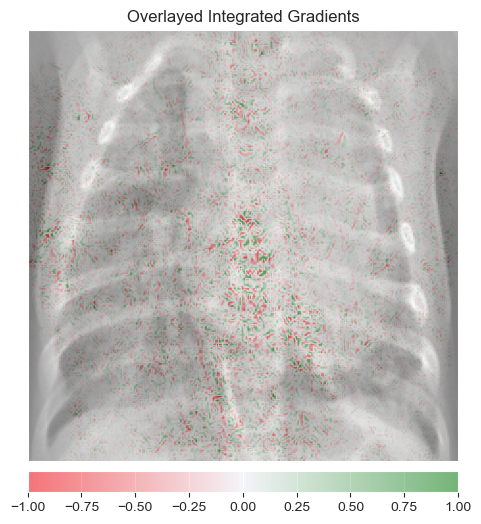

Predicted label 1, true label 1


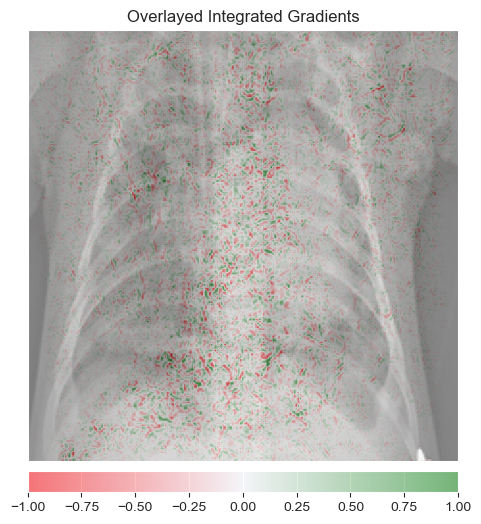

Predicted label 1, true label 1


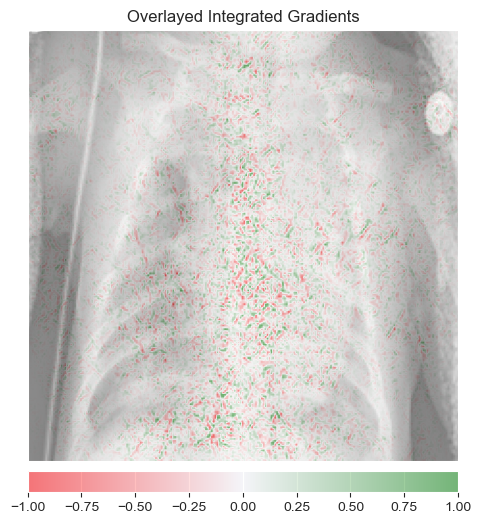

Predicted label 1, true label 1


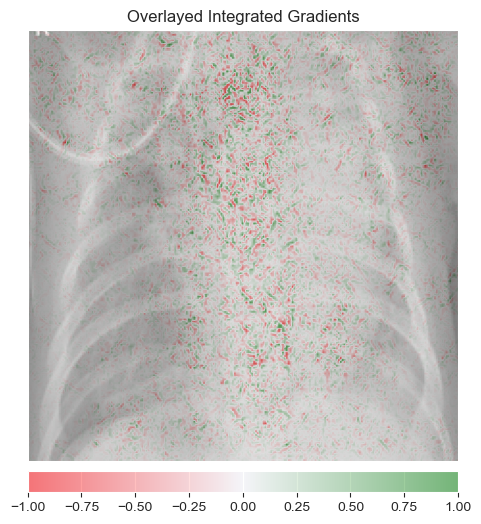

Predicted label 1, true label 1


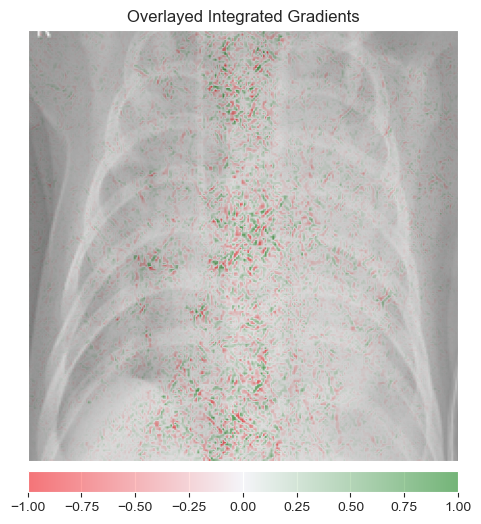

In [114]:
for i in range(len(attr_idx1)):
    test_img = test_images[idx1[i]]
    true_label = test_labels[idx1[i]]
    transformed_img = transform(test_img)
    input_img = transformed_img.unsqueeze(0) # the model requires a dummy batch dimension
    pred_label = int(test_single_image(model,input_img))
    attributions_ig = attr_idx0[i]
    print(f"Predicted label {pred_label}, true label {true_label}")
    _ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(input_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                method='blended_heat_map',
                                sign='all',
                                show_colorbar=True,
                                title='Overlayed Integrated Gradients')
    time.sleep(1)

The above pictures rapresent the integrated gradient method applied for the patients that have the pneumonia and doesn't have the pneumonia.
It is possible to notice that for patient that doesn't have the pneumonia the model focuses more on the lounges and on the vertical spine. 
On the contrary for patients that presents the pneumonia, it possible to notice that the model focuse on a much wider area, next to the lounges. This behaviour can be compared to the behaviour of a clinicians, in fact when the patients has the pneumonia the X-ray present a big white area aroung the lounges